In [1]:
import os
import tweepy as tw
import pandas as pd
import yaml

import re
import unicodedata
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

# Step 1: Set up Twitter API access
Set up the project here: https://developer.twitter.com/en/portal/projects-and-apps

Using this site as reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

In [2]:
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# Step 2: Get tweets and transform into dataframe

In [4]:
# Reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

# define parameters for API request
search_word = "#covidcanada"
num_of_tweets = 1000
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

In [5]:
# Twitter API data dictionary: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet

# Get column names
api_colnames_call = api.search(q=search_word, count=num_of_tweets)
json_data = [c._json for c in api_colnames_call]

# create dataframe from JSON result
api_colnames = pd.json_normalize(json_data)

'''
# print all column names
for col in api_colnames.columns:
    print(col)
'''

'\n# print all column names\nfor col in api_colnames.columns:\n    print(col)\n'

In [6]:
# Specify which columns to pull from API
tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

print(tweet_metadata[:2])

[[datetime.datetime(2021, 6, 18, 3, 48, 57), 1405734251274727431, 'COVID-19: Second dose of AstraZeneca vaccine no longer recommended in Canada https://t.co/1XOuLE6umR #NACI #AstraZenecaVaccine #COVIDCanada #COVID19Canada #COVIDVaccination #COVID19Vaccination', 'iChinadian', 0, 0], [datetime.datetime(2021, 6, 18, 3, 47, 41), 1405733931555557382, 'COVID-19: B.C.’s approach to AstraZeneca unchanged after NACI recommendation https://t.co/KvAIqEyF8B #COVIDBC #COVID19BC #COVIDCanada #COVID19Canada #AstraZenecaVaccine #COVIDVaccination #COVID19Vaccination', 'iChinadian', 1, 0]]


In [7]:
# Create a pandas dataframe
df_tweets_raw = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])
df_tweets_raw['created_dt'] = df_tweets_raw['created_at'].dt.date

df_tweets_raw.head()

,created_at,id,full_text,user,rt_count,fav_count,created_dt
0,2021-06-18 03:48:57,1405734251274727431,COVID-19: Second dose of AstraZeneca vaccine n...,iChinadian,0,0,2021-06-18
1,2021-06-18 03:47:41,1405733931555557382,COVID-19: B.C.’s approach to AstraZeneca uncha...,iChinadian,1,0,2021-06-18
2,2021-06-18 03:46:06,1405733535231606793,COVID-19 hospitalizations in B.C. hit new seve...,iChinadian,0,0,2021-06-18
3,2021-06-18 03:30:01,1405729485421486082,‘A slippery slope towards cartel-like conduct:...,ap236,1,0,2021-06-18
4,2021-06-18 03:29:34,1405729374159228928,This is so satisfying to watch...\n\n#COVIDVac...,Ortho_PA,1,4,2021-06-18


# Step 3: Basic exploratory data analysis (EDA)

In [8]:
print('Rows:', df_tweets_raw.shape[0], '\nColumns:', df_tweets_raw.shape[1])

Rows: 152 
Columns: 7


In [9]:
max_tweet_length = df_tweets_raw.full_text.apply(len).max()
print('Longest tweet is', max_tweet_length, 'characters long')

Longest tweet is 306 characters long


In [10]:
min_date = df_tweets_raw.created_at.min()
max_date = df_tweets_raw.created_at.max()

print('Min. date: ', min_date, '\nMax. date: ', max_date)

Min. date:  2021-06-10 01:50:01 
Max. date:  2021-06-18 03:48:57


In [11]:
df_tweets_raw.describe(include='all')

<ipython-input-11-4d9704376e2a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_tweets_raw.describe(include='all')


,created_at,id,full_text,user,rt_count,fav_count,created_dt
count,152,1.520000e+02,152,152,152.000000,152.000000,152
unique,152,NaN,152,34,NaN,NaN,9
top,2021-06-16 00:56:05,NaN,B.C.'s key COVID-19 metrics keep falling https...,iChinadian,NaN,NaN,2021-06-12
freq,1,NaN,1,65,NaN,NaN,21
first,2021-06-10 01:50:01,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-06-18 03:48:57,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.404372e+18,NaN,NaN,0.309211,0.986842,NaN
std,NaN,9.223339e+14,NaN,NaN,0.893194,2.865614,NaN
min,NaN,1.402805e+18,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,1.403558e+18,NaN,NaN,0.000000,0.000000,NaN


# Step 4: Feature Extraction (before text cleaning)
* Count of Stopwords
* Count of @ characters
* Count of Hashtag characters
* Count of Numeric characters
* Count of Punctuation
* Count of Emojis 😜
* Count of Emoticons :-)

In [12]:
# Load libraries
#!pip install -q wordcloud
#import wordcloud
from nltk.corpus import stopwords
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Step 4a: Pre-cleaning counts (easy)

In [13]:
# Easy ones: Stopwords, hashtags, numerics, uppercase, & punctuation

# Create pre-clean character count feature
df_tweets_raw['character_ct'] = df_tweets_raw.full_text.apply(lambda x: len(x))

# Create stopword count feature
df_tweets_raw['stopword_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x in stop]))

# Create hashtag count feature
df_tweets_raw['hashtag_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Create @ sign count feature
df_tweets_raw['atsign_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Create numeric count feature
df_tweets_raw['numeric_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# Create an uppercase count feature
df_tweets_raw['stopword_ct'] = df_tweets_raw.full_text.apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Create punctuation count feature
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

df_tweets_raw['punctuation_ct'] = df_tweets_raw.full_text.apply(lambda x: count_punct(x))


# See all new columns
df_tweets_raw[['full_text', 'stopword_ct', 'hashtag_ct', 'atsign_ct', 'numeric_ct', 'punctuation_ct', 'character_ct']].sort_values(by='stopword_ct', ascending=False).head(3)

,full_text,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,character_ct
129,2ND VACCINE BOOKED FOR THIS SUNDAY!!!\n🎉💉💓💉🎊💉🙌...,6,4,0,0,12,118
42,Jun 15\n\nCDN Cases and Deaths\n\nYK &amp; NVT...,5,16,0,1,25,306
26,Here is what to expect following your second C...,5,10,1,0,18,244


In [14]:
def feature_extract(df):
    # Load in english stopwords
    stop = stopwords.words('english')
    
    # Create pre-clean character count feature
    df['character_ct'] = df.full_text.apply(lambda x: len(x))
    # Create stopword count feature
    df['stopword_ct'] = df.full_text.apply(lambda x: len([x for x in x.split() if x in stop]))
    # Create hashtag count feature
    df['hashtag_ct'] = df.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    # Create @ sign count feature
    df['atsign_ct'] = df.full_text.apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
    # Create numeric count feature
    df['numeric_ct'] = df.full_text.apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    # Create an uppercase count feature
    df['stopword_ct'] = df.full_text.apply(lambda x: len([x for x in x.split() if x.isupper()]))
    # Create punctuation count feature
    count = sum([1 for char in df.full_text if char in string.punctuation])
    df['punctuation_ct'] = df_tweets_raw.full_text.apply(lambda x: count_punct(x))
    return df

df3 = feature_extract(df_tweets_raw)

df3.head(4)

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct
0,2021-06-08 13:02:22,1402249644248293381,Trudeau should quarantine in same hotel as oth...,cdallen21,1,0,2021-06-08,213,1,5,0,0,16
1,2021-06-08 03:30:03,1402105616278208514,Air Canada’s senior executives to return 2020 ...,ap236,0,1,2021-06-08,186,1,8,0,1,13
2,2021-06-08 02:16:10,1402087021301035012,"12 die in B.C. from COVID-19 on weekend, as ne...",iChinadian,0,0,2021-06-08,155,4,4,1,1,14
3,2021-06-08 02:15:57,1402086968368893952,"B.C. COVID cases, hospitalizations fall; about...",iChinadian,0,0,2021-06-08,154,4,4,0,0,13


## Step 4b: Pre-cleaning counts (hard)

In [14]:
# Harder ones: Emojis, Emoticons

#TODO Right now, this code only counts some emojis, and a distinct count.. ? Needs work!

# Load libraries for emoji & regex
import emoji
import regex
import re

# Define function to remove emojis
def count_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

# Emoji count 
df_tweets_raw['emoji_ct'] = df_tweets_raw.full_text.apply(lambda x: len(count_emoji(x)))

# See a few 
df_tweets_raw[['full_text', 'emoji_ct']].sort_values('emoji_ct',ascending=False).head(3)

,full_text,emoji_ct
35,🚨 Most HIV infections by country per capita 🚨\...,2
61,"Updated (June 14, 2021) summary of the #Canadi...",1
88,"Updated (June 13, 2021) summary of the #Canadi...",1


In [15]:
# TODO: THIS
#   Write a function to identify all the emoticons, call it emoticon_ct

# See 3 rows
# df[['text','emoticon_ct']].head(3)



## Part 5: Sentiment Analysis
* Import VADER functions
* Apply VADER sentiment analyzer to raw tweets, create output columns

In [16]:
# Create a copy to preserve the raw data
df_tweets = df_tweets_raw.copy()

df_tweets.head()

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct
0,2021-06-18 03:48:57,1405734251274727431,COVID-19: Second dose of AstraZeneca vaccine n...,iChinadian,0,0,2021-06-18,192,2,6,0,0,13,0
1,2021-06-18 03:47:41,1405733931555557382,COVID-19: B.C.’s approach to AstraZeneca uncha...,iChinadian,1,0,2021-06-18,206,4,7,0,0,16,0
2,2021-06-18 03:46:06,1405733535231606793,COVID-19 hospitalizations in B.C. hit new seve...,iChinadian,0,0,2021-06-18,144,4,4,1,0,14,0
3,2021-06-18 03:30:01,1405729485421486082,‘A slippery slope towards cartel-like conduct:...,ap236,1,0,2021-06-18,191,2,8,0,0,16,0
4,2021-06-18 03:29:34,1405729374159228928,This is so satisfying to watch...\n\n#COVIDVac...,Ortho_PA,1,4,2021-06-18,89,0,2,0,0,10,0


In [17]:
# Credit: https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text:str, analyser,desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Sentiment scores
def get_sentiment_scores(df, data_column):
    df[f'positive_score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'pos'))
    df[f'negative_score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'neg'))
    df[f'neutral_score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'neu'))
    df[f'compound_score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'compound'))
    return df


text_sentiment = get_sentiment_scores(df_tweets, 'full_text')

display(text_sentiment.sample(5))

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,positive_score,negative_score,neutral_score,compound_score
52,2021-06-15 20:07:34,1404893364760289280,Canada leads world in administering first-dose...,DailyHiveVan,4,21,2021-06-15,125,1,1,0,0,13,0,0.000,0.0,1.000,0.0000
66,2021-06-15 01:09:29,1404606955407163393,@ColeEvyx Hoping everything goes smoothly when...,UltrosJelis,0,1,2021-06-15,119,0,1,1,0,5,0,0.154,0.0,0.846,0.4753
91,2021-06-13 16:00:34,1404106430655852548,Ontario reports more than 500 new COVID-19 cas...,iChinadian,0,0,2021-06-13,141,1,2,1,1,9,0,0.106,0.0,0.894,0.2263
44,2021-06-16 00:56:05,1404965973346570240,"COVID-19: B.C. reports 108 new cases, zero dea...",iChinadian,0,0,2021-06-16,121,4,4,0,1,14,0,0.000,0.0,1.000,0.0000
40,2021-06-16 03:09:37,1404999578110201862,Elections Canada says it's ready for a COVID-1...,iChinadian,0,0,2021-06-16,157,1,3,1,0,12,0,0.122,0.0,0.878,0.3612


In [18]:

# classify based on VADER readme rules
def sentiment_classifier(df, data_column):

    # create a list of our conditions
    conditions = [
        (df[data_column] >= 0.05),
        (df[data_column] > -0.05) & (df[data_column] < 0.05),
        (df[data_column] <= -0.05),
        ]

    # create a list of the values we want to assign for each condition
    values = ['positive', 'neutral', 'negative']
    
    # apply
    df['sentiment'] = np.select(conditions, values)
    return df

test = sentiment_classifier(df_tweets, 'compound_score')

display(test.sample(5))

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,positive_score,negative_score,neutral_score,compound_score,sentiment
40,2021-06-16 03:09:37,1404999578110201862,Elections Canada says it's ready for a COVID-1...,iChinadian,0,0,2021-06-16,157,1,3,1,0,12,0,0.122,0.000,0.878,0.3612,positive
139,2021-06-10 11:40:00,1402953691238473729,💉⚕️🇨🇦\n\nConfusion about what you can do once ...,vubblePOP,0,0,2021-06-10,226,1,10,1,0,16,1,0.000,0.084,0.916,-0.2960,negative
100,2021-06-12 22:58:27,1403849203831296001,How vaccines can crush the variants and make r...,iChinadian,0,1,2021-06-12,205,1,6,0,0,12,0,0.000,0.071,0.929,-0.1531,negative
109,2021-06-12 03:46:59,1403559430323462144,People's Party of Canada Leader Maxime Bernier...,iChinadian,0,0,2021-06-12,162,3,5,0,0,12,0,0.109,0.125,0.766,-0.1027,negative
118,2021-06-11 22:15:21,1403475969797771265,Congrats to BC who have surpassed 75 per cent ...,PasiekaOnPol,0,1,2021-06-11,115,1,2,0,1,4,0,0.178,0.000,0.822,0.5707,positive


In [40]:
def print_top_n_reviews(df, data_column, num_rows):
    text = 'full_text'
    for tweet, row in df.nlargest(num_rows, data_column).iterrows():
        print(f"Score: {row[data_column]}, Tweet: {row[text]}")
    return df

res = print_top_n_reviews(text_sentiment , 'positive_score', 5)

res

Score: 0.594, Tweet: Great news! #COVIDCanada https://t.co/yIIuKmbEu9
Score: 0.577, Tweet: Amazing! #GetVaccinated #covidcanada https://t.co/QZX52LYiG7
Score: 0.499, Tweet: Help Manitoba! #CovidCanada https://t.co/ZQjYbl0XSP
Score: 0.373, Tweet: 2ND VACCINE BOOKED FOR THIS SUNDAY!!!
🎉💉💓💉🎊💉🙌🥳💉
#TeamModerna #grateful #covid19Qc #CovidCanada https://t.co/pCGbaBgyLu
Score: 0.338, Tweet: Yes, #Covidzero  #covidcanada people. Here is  a thread worth unraveling. https://t.co/CQCs7zcXcR


,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,positive_score,negative_score,neutral_score,compound_score,sentiment
0,2021-06-18 03:48:57,1405734251274727431,COVID-19: Second dose of AstraZeneca vaccine n...,iChinadian,0,0,2021-06-18,192,2,6,0,0,13,0,0.000,0.192,0.808,-0.4199,negative
1,2021-06-18 03:47:41,1405733931555557382,COVID-19: B.C.’s approach to AstraZeneca uncha...,iChinadian,1,0,2021-06-18,206,4,7,0,0,16,0,0.000,0.000,1.000,0.0000,neutral
2,2021-06-18 03:46:06,1405733535231606793,COVID-19 hospitalizations in B.C. hit new seve...,iChinadian,0,0,2021-06-18,144,4,4,1,0,14,0,0.000,0.130,0.870,-0.2732,negative
3,2021-06-18 03:30:01,1405729485421486082,‘A slippery slope towards cartel-like conduct:...,ap236,1,0,2021-06-18,191,2,8,0,0,16,0,0.000,0.065,0.935,-0.1027,negative
4,2021-06-18 03:29:34,1405729374159228928,This is so satisfying to watch...\n\n#COVIDVac...,Ortho_PA,1,4,2021-06-18,89,0,2,0,0,10,0,0.326,0.000,0.674,0.5949,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2021-06-10 03:26:15,1402829435686977543,"COVID-19: B.C. records 148 cases, three deaths...",iChinadian,0,0,2021-06-10,118,4,4,0,1,14,0,0.000,0.000,1.000,0.0000,neutral
148,2021-06-10 03:04:58,1402824078105333760,"Updated (June 9, 2021) summary of the #Canadia...",WestKelownian,0,0,2021-06-10,251,3,9,1,0,22,1,0.000,0.000,1.000,0.0000,neutral
149,2021-06-10 02:54:30,1402821447622475777,"https://t.co/UWs099Xayl Hello, #covidzero #moc...",yaxl_to,0,0,2021-06-10,142,0,4,0,0,12,0,0.139,0.000,0.861,0.4404,positive
150,2021-06-10 02:45:43,1402819233583538184,The Dose - Are you having a two-dose summer? W...,HoustyGary,0,1,2021-06-10,155,1,3,0,0,11,1,0.097,0.000,0.903,0.4404,positive


In [78]:
top_tweet_list = []

def print_top_n_reviews(df, data_column, num_rows):
    text = 'full_text'
    top = df.nlargest(num_rows, data_column)
    top_tweets = df[[data_column,text]]
    return top_tweets

res = print_top_n_reviews(text_sentiment , 'positive_score', 5)

res

In [79]:
num_rows = 5
data_column = 'positive_score'
text = 'full_text'
df = text_sentiment
top = df.nlargest(num_rows, data_column)
top_tweets = top[[data_column,text]]
top_tweets

,positive_score,full_text
103,0.594,Great news! #COVIDCanada https://t.co/yIIuKmbEu9
126,0.577,Amazing! #GetVaccinated #covidcanada https://t...
23,0.499,Help Manitoba! #CovidCanada https://t.co/ZQjYb...
129,0.373,2ND VACCINE BOOKED FOR THIS SUNDAY!!!\n🎉💉💓💉🎊💉🙌...
86,0.338,"Yes, #Covidzero #covidcanada people. Here is ..."


In [82]:
sent_type = 'Positive'
   
if sent_type == 'Positive':
    sent_nm= 'positive_score'

# Scenario 2: Bigrams
if sent_type== 'Neutral':
    sent_nm == 'neutral_score'

# Scenario 3: Trigrams
if sent_type == 'Negative':
    sent_nm == 'negative_score'
    
text = 'full_text'
top = df.nlargest(num_rows, sent_tp)
top_tweets = top[[sent_nm,text]]

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

## Part 6: Data & Text Cleaning
* Change to lower case
* Remove punctuation, stopwords, URLs, html tags, emojis, emoticons
* Spell correction
* Explore & remove custom stopwords

In [17]:
# Create a copy to preserve the raw data
df_tweets = df_tweets_raw.copy()

# Sample the tweets
df_tweets_raw.full_text[26]

'Delta variant heightens urgency for second doses to stop spread, scientists say https://t.co/BCUAUKsZST via @CTVNews #COVIDCanada #COVID19Canada #B1617'

In [18]:
# View more sample tweets
for i in range(0,5):
    print(str(i+1) + ') ' + df_tweets_raw.full_text[i] + '\n')

1) Trudeau should quarantine in same hotel as other travellers, Conservatives say - National Post. I love this idea!!! #quarantinetrudeau #liberalhypocrisy #trudeausucks #cdnpoli #covidcanada  https://t.co/O6o5KtbvC5

2) Air Canada’s senior executives to return 2020 bonuses over ‘public disappointment’ https://t.co/GkssN1VZIh #COVIDCanada #Bonuses #COVID19 #AirCanada #Bailout #Coronavirus #cdnpoli #snrtg

3) 12 die in B.C. from COVID-19 on weekend, as new infections stay low https://t.co/RZYrc6aArq via @viawesome  #COVIDBC #COVIDCanada #COVID19BC #COVID19Canada

4) B.C. COVID cases, hospitalizations fall; about three quarters of adults vaccinated https://t.co/7WEKDsoVWo #COVIDBC #COVIDCanada #COVID19BC #COVID19Canada

5) Updated (June 7, 2021) summary of the #Canadian #COVID19 #pandemic based on @GovCanHealth data. #Canada has administered #vaccine doses corresponding to about 69.91% of its population. #COVIDー19 #COVIDCanada #COVID2019 #cdnpoli https://t.co/fdIUwfQgDG



## Step 6a: Convert tweets to lower case

In [19]:
# Convert transcripts to lower case
df_tweets['text_cleaned'] = df_tweets['full_text'].map(lambda x: x.lower())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency for second doses to stop spread, scientists say https://t.co/bcuaukszst via @ctvnews #covidcanada #covid19canada #b1617


## Step 6b: Remove URLs, html tags, punctuation, stopwords, emojis, emoticons

In [20]:
# Remove tweet URLs
df_tweets['text_cleaned'] = df_tweets.text_cleaned.map(lambda x: re.sub(r'https\:\/\/t\.co\/*\w*', '', x, flags=re.MULTILINE).strip())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency for second doses to stop spread, scientists say  via @ctvnews #covidcanada #covid19canada #b1617


In [21]:
# Remove punctuation
df_tweets['text_cleaned'] = df_tweets.text_cleaned.str.replace('[^\w\s]','')

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency for second doses to stop spread scientists say  via ctvnews covidcanada covid19canada b1617
<ipython-input-21-3fcf730612d2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets['text_cleaned'] = df_tweets.text_cleaned.str.replace('[^\w\s]','')


In [22]:
# Remove stopwords (start with library to identify stopwords)
from nltk.corpus import stopwords

# Define english & french stopwords 
stop_en = stopwords.words('english')
stop_fr = stopwords.words('french')

# Remove english & french stopwords
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: " ".join(x for x in x.split() if x not in stop_en))
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: " ".join(x for x in x.split() if x not in stop_fr))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency second doses stop spread scientists say via ctvnews covidcanada covid19canada b1617


In [23]:
# Define function to remove emojis --> e.g. 😜
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove all emojis
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: remove_emoji(x))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency second doses stop spread scientists say via ctvnews covidcanada covid19canada b1617


In [24]:
# Define function to remove emoticons --> e.g. :-)

# Libraries
!pip install emot
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

# Remove all emoticons
df_tweets['text_cleaned'] = df_tweets.text_cleaned.apply(lambda x: remove_emoticons(x))

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
delta variant heightens urgency second doses stop spread scientists say via ctvnews covidcanada covid19canada b1617


## Step 6c: Tokenize and lemmatize tweets
Tokenization parses tweets into individual words and lemmatization removes inflectional endings (ie. endings that add grammatical meaning). These methods prepare the data for word frequency and n-gram analysis.

Methods used below reference this post: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

In [25]:
def clean_text_round1(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # remove emoji
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = ' ' + text # added space because there was some weirdness for first word (strip later)
    text = text.lower() # convert all text to lowercase
    text = re.sub(r'(\s)@\w+', '', text) # remove whole word if starts with @
    text = re.sub(r'(\s)\w*\d\w*\w+', '', text) # remove whole word if starts with number
    text = re.sub(r'https\:\/\/t\.co\/*\w*', '', text) # remove https links
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # removes punctuation
    text = re.sub('\[.*?\]', '', text) # removes text in square brackets
    #text = re.sub('\w*\d\w*', '', text) # remove whole word if starts with number
    #text = re.sub(r'(\s)#\w+', '', text) # remove whole word if starts with #
    text = text.strip()
    return text

round1 = lambda x: clean_text_round1(x)

df_tweets_raw['clean_text'] = df_tweets_raw.full_text.apply(round1)
print("Cleaned tweet:\n" + df_tweets_raw['clean_text'][4])


Cleaned tweet:
updated june 7 summary of the canadian covid19 pandemic based on data canada has administered vaccine doses corresponding to about91 of its population covid19 covidcanada covid2019 cdnpoli


In [26]:
def round3_text_clean(text):
    #TODO: add emoticons and emojis to this!
    # Load in stopwords
    stopwords_en = nltk.corpus.stopwords.words('english')
    stopwords_fr = nltk.corpus.stopwords.words('french')
    stopwords = stopwords_en + stopwords_fr
    # Create pre-clean character count feature
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
    return text

df3 = round3_text_clean(df_tweets_raw.full_text)

df3.head(4)

0    Trudeau quarantine hotel travellers, Conservat...
1    Air Canada’s senior executives return 2020 bon...
2    12 die B.C. COVID-19 weekend, new infections s...
3    B.C. COVID cases, hospitalizations fall; three...
Name: full_text, dtype: object

## Step 6d: Word correction (needs work & review!)

In [27]:
#TODO Check to see if this worked as intended...

# Spell correction 
from textblob import TextBlob
df_tweets['text_cleaned'] = df_tweets.text_cleaned.[:5].apply(lambda x: str(TextBlob(x).correct()))

SyntaxError: invalid syntax (<ipython-input-27-eb4c98db4780>, line 5)

# Step 7: Text analytics (analyze tweets)

## Step 7a: Word frequencies and n-grams

In [48]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import unicodedata


def text_clean_round2(text):
    """
    A simple function to clean up the data. All the words that
    are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore'))
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


# Word cloud
txt = text_clean_round2(''.join(str(df_tweets.text_cleaned.tolist())))


# Python program to convert a list
# to string using join() function
    
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))
        
        
# Driver code    
print(listToString(txt)) 




trudeau quarantine hotel traveller conservative say national post love idea quarantinetrudeau liberalhypocrisy trudeausucks cdnpoli covidcanada air canada senior executive return 2020 bonus public disappointment covidcanada bonus covid19 aircanada bailout coronavirus cdnpoli snrtg 12 die bc covid19 weekend new infection stay low via viawesome covidbc covidcanada covid19bc covid19canada bc covid case hospitalization fall three quarter adult vaccinated covidbc covidcanada covid19bc covid19canada updated june 7 2021 summary canadian covid19 pandemic based govcanhealth data canada administered vaccine dos corresponding 6991 population covid19 covidcanada covid2019 cdnpoli canada eyeing multistage approach reopening border traveller cbc news cdnpoli covidcanada covid19canada covid19 covid_19 find trusted information covid19 vaccine covidcanada healthliteracy ontario begin reopening friday 3rd wave covid19 recedes cbc news covidcanada covidon covidontario covid19canada covid19on covid19ontar

In [137]:
def tweets_ngrams(n, top_n):
    result = (pd.Series(nltk.ngrams(words, n)).value_counts())[:top_n]
    return result

word_series = tweets_ngrams(1, 15)
bigram_series = tweets_ngrams(2, 15)
trigram_series = tweets_ngrams(3, 15)

bigram_series

(covid19on, covidcanada)        25
(covidcanada, covid19canada)    22
(covidtoronto, covid19on)       21
(covidcanada, covidbc)          20
(covid19, case)                 18
(covidbc, covidab)              16
(covid19, covidcanada)          15
(covidab, covidsk)              14
(cbc, news)                     14
(covid19, vaccine)              13
(vaccine, dos)                  13
(covidbc, covidcanada)          12
(covid19bc, covid19canada)      11
(may, 31)                       11
(new, case)                     11
dtype: int64

In [ ]:
#TODO: visualize word frequencies in horizontal bar charts

In [138]:
sns.set_style('whitegrid')
%matplotlib inline

C:\Users\dofayad\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


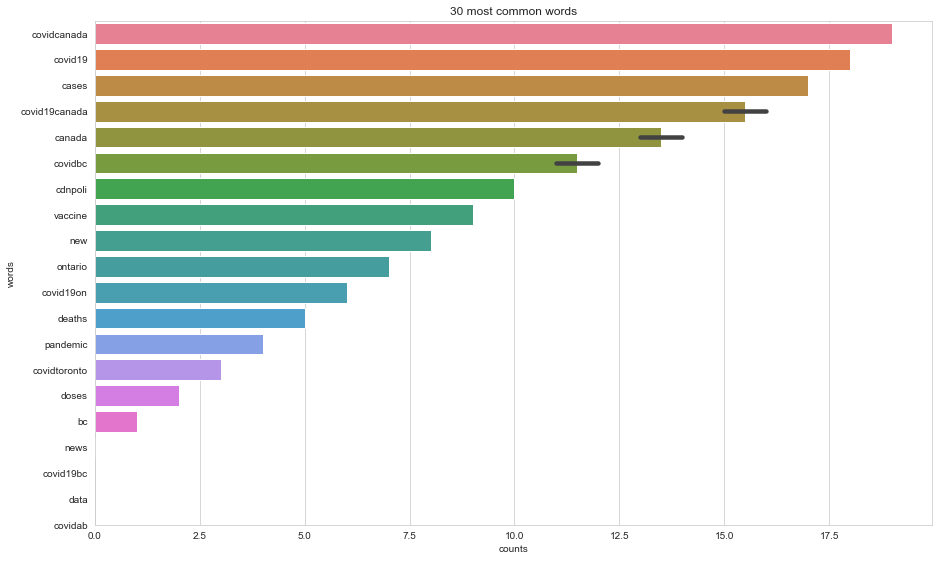

In [114]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl', orient = 'h')
    plt.yticks(x_pos, words) 
    plt.ylabel('words')
    plt.xlabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['text_cleaned'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

## Step 7b: Sentiment analysis

In [139]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
from textblob import TextBlob

# Make sure df_tweets.full_text is a string
df_tweets['full_text']= df_tweets.full_text.astype(str)

# Define functions
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

# Run functions and create columns in df_tweets
df_tweets['polarity'] = df_tweets.full_text.apply(pol)
df_tweets['subjectivity'] = df_tweets.full_text.apply(sub)

# Round scores
df_tweets['polarity'] = df_tweets.polarity.round(3)
df_tweets['subjectivity'] = df_tweets.subjectivity.round(3)


# See first 3 rows
df_tweets.head(3)

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,text_cleaned,polarity,subjectivity
0,2021-06-04 22:36:04,1400944471550967810,The ethics and concerns of disclosing the name...,EACOOntario,0,0,2021-06-04,174,2,4,0,0,11,0,ethics concerns disclosing names businesses co...,0.00,0.00
1,2021-06-04 22:11:55,1400938390128844802,@dubsndoo Because she’s the only one with #cov...,CarlsonRalph,0,0,2021-06-04,54,0,1,1,0,2,0,dubsndoo shes one covidcanada,0.00,1.00
2,2021-06-04 18:20:58,1400880272963518465,Today's coronavirus news: Toronto is opening m...,torontodotcom,0,0,2021-06-04,295,1,4,0,0,19,0,todays coronavirus news toronto opening 10000 ...,0.25,0.25


In [177]:
df_tweets['polarity'] = df_tweets.full_text.apply(pol)
df_tweets['subjectivity'] = df_tweets.full_text.apply(sub)

df_tweets.head(3)

,created_at,id,full_text,user,rt_count,fav_count,created_dt,character_ct,stopword_ct,hashtag_ct,atsign_ct,numeric_ct,punctuation_ct,emoji_ct,text_cleaned,polarity,subjectivity
0,2021-06-04 22:36:04,1400944471550967810,The ethics and concerns of disclosing the name...,EACOOntario,0,0,2021-06-04,174,2,4,0,0,11,0,ethics concerns disclosing names businesses co...,0.00,0.00
1,2021-06-04 22:11:55,1400938390128844802,@dubsndoo Because she’s the only one with #cov...,CarlsonRalph,0,0,2021-06-04,54,0,1,1,0,2,0,dubsndoo shes one covidcanada,0.00,1.00
2,2021-06-04 18:20:58,1400880272963518465,Today's coronavirus news: Toronto is opening m...,torontodotcom,0,0,2021-06-04,295,1,4,0,0,19,0,todays coronavirus news toronto opening 10000 ...,0.25,0.25


In [187]:
df_tweets_grouped = df_tweets[['created_dt', 'id']].groupby(['created_dt']).agg(['nunique']).reset_index()

df_tweets_grouped.columns = ['tweet_date', 'tweets']

df_tweets_grouped

,tweet_date,tweets
0,2021-05-28,22
1,2021-05-29,29
2,2021-05-30,19
3,2021-05-31,15
4,2021-06-01,26
5,2021-06-02,21
6,2021-06-03,28
7,2021-06-04,17


In [140]:
df_count = df_tweets[['stopword_en_ct', 'stopword_fr_ct', 'hashtag_ct', 'atsign_ct', 'link_ct', 'numeric_ct', 'uppercase_ct']]
df_count_transposed = df_count.T

df_count_transposed

KeyError: "['link_ct', 'stopword_fr_ct', 'uppercase_ct', 'stopword_en_ct'] not in index"